In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [2]:
from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from analysis.helper import PLATFORMS, COLORS
from analysis.helper import postgres_data

warnings.filterwarnings('ignore')


ALPHA = .05

## **Activity Analysis for 2024**

> **Note:** The data reflects only `activity points`. This means that if a player earns an achievement, it indicates that they are actively playing the game.  
> However, the absence of achievements does not necessarily mean the game is **not being played**  

<i>Example:</i> CS2 has only one achievement, yet millions play it daily

In [3]:
# A dictionary where the keys - platform names,
# and the values - DataFrames of the `history` table
activities = {}
for platform in PLATFORMS:
    activities[platform] = postgres_data(platform, 'history')

activities[PLATFORMS[0]].head(3)

,playerid,achievementid,date_acquired
0,76561198060698936,49520_Achievement_1,2024-09-08 17:35:20
1,76561198060698936,49520_Achievement_2,2024-09-08 22:07:24
2,76561198060698936,49520_Achievement_3,2024-09-08 22:07:24


In [4]:
# PRIMARY KEY = UniqueGameID + '_' + NonUniqueAchievID
def define_game(achievementid: str) -> int:
    return int(achievementid.split('_')[0])

In [5]:
for platform in PLATFORMS:
    activities[platform]['gameid'] = activities[platform].achievementid.apply(define_game)

    # Extracting YYYY-MM-DD, YYYY-MM, MM, WD, HH from the achievement's timestamp
    activities[platform]['date'] = activities[platform].date_acquired.dt.date
    activities[platform]['year_month'] = activities[platform].date_acquired.dt.to_period('M')
    activities[platform]['month'] = activities[platform].date_acquired.dt.month
    activities[platform]['weekday'] = activities[platform].date.apply(datetime.isoweekday)
    activities[platform]['hour'] = activities[platform].date_acquired.dt.hour.astype('int8')

activities[PLATFORMS[0]].head(3)

,playerid,achievementid,date_acquired,gameid,date,year_month,month,weekday,hour
0,76561198060698936,49520_Achievement_1,2024-09-08 17:35:20,49520,2024-09-08,2024-09,9,7,17
1,76561198060698936,49520_Achievement_2,2024-09-08 22:07:24,49520,2024-09-08,2024-09,9,7,22
2,76561198060698936,49520_Achievement_3,2024-09-08 22:07:24,49520,2024-09-08,2024-09,9,7,22


We use the preprocessed data from the `games` table, obtained in the `overview.ipynb` notebook,  
and remove irrelevant games from the `history` table

In [6]:
# A dictionary where the keys are platform names,
# and the values are set of relevant gameids
gameids = {}
for platform in PLATFORMS:
    gameids[platform] = set(pd.read_csv(f'games_{platform}.csv').gameid)

    activities[platform] = activities[platform].query('gameid in @gameids[@platform]')

activities[PLATFORMS[0]].head(3)

,playerid,achievementid,date_acquired,gameid,date,year_month,month,weekday,hour
0,76561198060698936,49520_Achievement_1,2024-09-08 17:35:20,49520,2024-09-08,2024-09,9,7,17
1,76561198060698936,49520_Achievement_2,2024-09-08 22:07:24,49520,2024-09-08,2024-09,9,7,22
2,76561198060698936,49520_Achievement_3,2024-09-08 22:07:24,49520,2024-09-08,2024-09,9,7,22


### **Analysis of the Hourly, Weekly, Monthly Activity**

In [7]:
def _activity(dataframe: pd.DataFrame, period: str) -> pd.DataFrame:
    return (
        dataframe[period]
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )

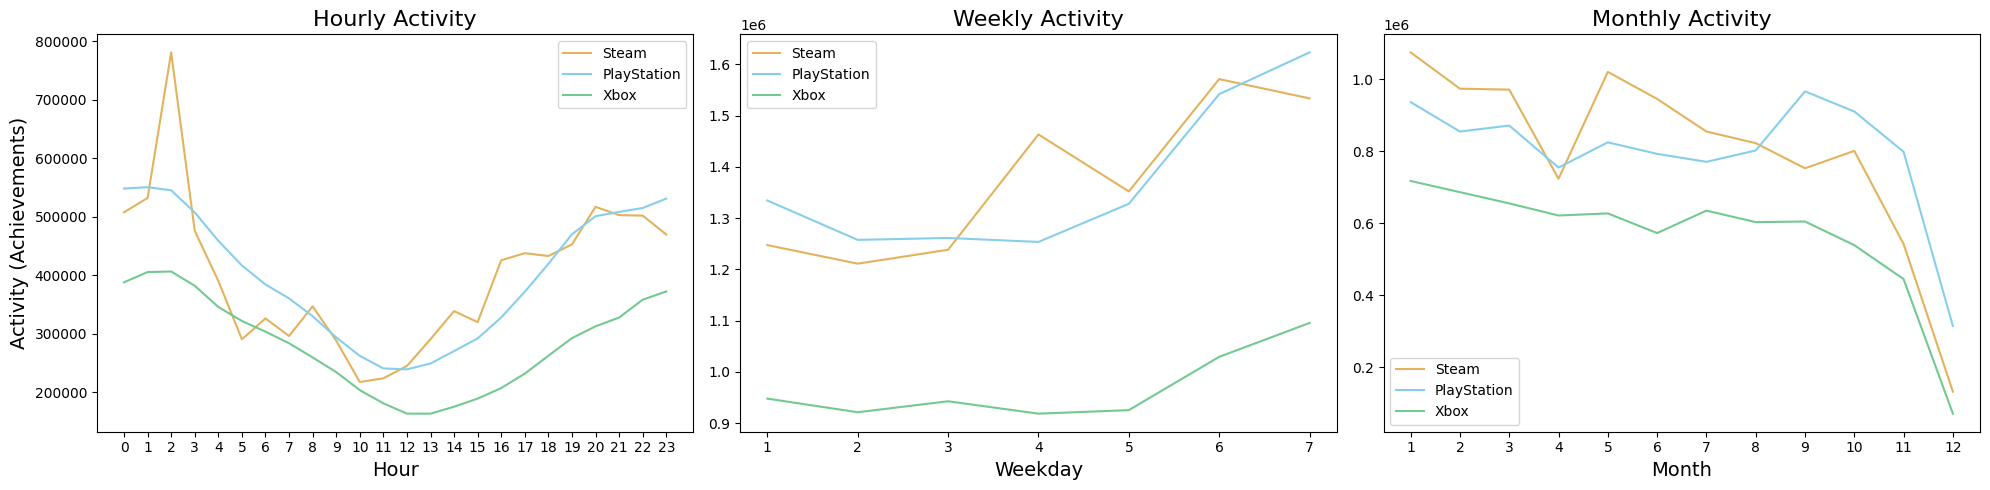

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    hourly = _activity(activities[platform], 'hour')
    weekdays = _activity(activities[platform], 'weekday')
    monthly = _activity(activities[platform], 'month')

    sns.lineplot(x=hourly.hour, y=hourly.quantity, color=color, ax=axes[0], label=label)
    sns.lineplot(x=weekdays.weekday, y=weekdays.quantity, color=color, ax=axes[1], label=label)
    sns.lineplot(x=monthly.month, y=monthly.quantity, color=color, ax=axes[2], label=label)
    
axes[0].set_xlabel('Hour', fontsize=14)
axes[0].set_ylabel('Activity (Achievements)', fontsize=14)
axes[0].set_xticks(hourly.hour.unique())
axes[0].set_title('Hourly Activity', fontsize=16)
axes[0].legend()

axes[1].set_xlabel('Weekday', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_title('Weekly Activity', fontsize=16)
axes[1].legend()

axes[2].set_xlabel('Month', fontsize=14)
axes[2].set_ylabel('')
axes[2].set_xticks(monthly.month.unique())
axes[2].set_title('Monthly Activity', fontsize=16)
axes[2].legend()

plt.tight_layout()

> **Note:** The significance of the last two months in the `Monthly Activity 2024` graph should be disregarded.  
> This sharp decline is due to the data collection method (see **documentation**).  
> Such a pattern is not observed in previous years

Each graph shows a general 'logical' trend for PlayStation and Xbox platforms,  
while Steam exhibits some inflated and noisy values (maximum at **2 AM**, and spike on **Thursday**)

### **Anomaly Detection on the Steam Platform**

Investigating Thursday and 2 AM separately to understand the cause of the sudden spike

In [9]:
# Calculating the number of achievements earned every Thursday throughout the entire year
activities[PLATFORMS[0]].query('weekday == 4').date.value_counts().describe()

count        50.000000
mean      29266.620000
std       46500.125112
min        3184.000000
25%       15671.250000
50%       19521.000000
75%       25458.250000
max      340039.000000
Name: count, dtype: float64

The maximum value deviates significantly from the average, even considering 2 $\sigma$  
Let's examine the data separately by players to see who and how many achievements were earned on Thursdays

In [10]:
activities[PLATFORMS[0]].query('weekday == 4').playerid.value_counts()

playerid
76561199014028512    319174
76561199643317571     50000
76561198837504437     24424
76561198854461127     23867
76561199421659790     20221
                      ...  
76561199113277338         1
76561198414941086         1
76561198066861094         1
76561198199822558         1
76561199309476552         1
Name: count, Length: 28308, dtype: int64

Examine the activity of the player `76561199014028512` separately

In [11]:
activities[PLATFORMS[0]].query('playerid == "76561199014028512"')

,playerid,achievementid,date_acquired,gameid,date,year_month,month,weekday,hour
8070074,76561199014028512,38600_ACH_26,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8070850,76561199014028512,38600_ACH_27,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8070938,76561199014028512,38600_ACH_28,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071090,76561199014028512,38600_ACH_29,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071153,76561199014028512,38600_ACH_30,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
...,...,...,...,...,...,...,...,...,...
8456156,76561199014028512,1373260_Popsicle,2024-05-09 03:25:19,1373260,2024-05-09,2024-05,5,4,3
8456157,76561199014028512,1373260_Stormhammer,2024-05-09 03:25:19,1373260,2024-05-09,2024-05,5,4,3
8456158,76561199014028512,1373260_Trap,2024-05-09 03:25:19,1373260,2024-05-09,2024-05,5,4,3
8456159,76561199014028512,1373260_BookFlame,2024-05-09 03:25:19,1373260,2024-05-09,2024-05,5,4,3


*It is important to know the following facts about the platforms:*
* In Steam, achievements can be hacked, which leads to increased playability, activity, and noise in the data
* On PlayStation and Xbox platforms, such issues do not occur. However, save transfers are possible,  
for example, from PS4 to PS5, which can result in achievements being unlocked immediately on the new platform

> As we can observe, some different achievements were earned at the exact same time, down to the second, which is highly unlikely to be possible

### **Detection of Achievement Manipulation**

**Core idea:** Calculate the delta between the acquisition of consecutive achievements,  
and if the percentage of identical deltas exceeds **65%** of the total achievements for a game, remove such data from the sample

In [12]:
# A dictionary where the keys - platform names,
# and the values - DataFrames of the `achievements` table,
# with the aggregated `total_achievements` column
achievements_df = {}
for platform in PLATFORMS:
    achievements_df[platform] = (
        postgres_data(platform, 'achievements')
        .query('gameid in @gameids[@platform]')
        .gameid
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'total'})
    )

achievements_df[PLATFORMS[0]].head(3)

,gameid,total
0,664290,10979
1,573060,9821
2,640310,5394


In [13]:
# A dictionary where the keys are platform names,
# and the values are processed data from the `history` table (free from manipulations)
clear_activities = {}
for platform in PLATFORMS:
    label = platform.capitalize().replace('s', 'S')

    # It is important to correctly determine the delta, so we sort the dataset by achievement acquisition date
    outliers = activities[platform][['playerid', 'gameid', 'date_acquired']].sort_values('date_acquired')

    outliers['prev_date_acquired'] = outliers.groupby(['playerid', 'gameid']).date_acquired.shift(1)

    # delta - number of minutes (float) between the previous and the next achievement earned
    outliers['delta'] = (outliers.date_acquired - outliers.prev_date_acquired).dt.total_seconds() / 60

    outliers_copy = (
        outliers.groupby(['playerid', 'gameid'])
        .delta
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'obtained'})
    )
    # Adding the total number of achievements to the table
    outliers_copy = outliers_copy.merge(achievements_df[platform], how='left')

    # Calculate the ratio of earned achievements to the total number of achievements
    outliers_copy['ratio'] = outliers_copy.obtained / outliers_copy.total * 100

    # Retain only games where the total number of achievements > 5,
    # since detecting manipulation with a smaller number is difficult.
    # For example, CS2 has only 1 achievement 'Play in CS2', resulting in a ratio of 100%
    # 6 achievements are sufficient to determine if manipulation has occurred.
    # Even if 3 achievements are earned in 1 second, the game's ratio would be 50% (such values are not excluded)
    outliers_copy = outliers_copy.query('total > 5')

    to_drop = outliers_copy.groupby(['playerid', 'gameid'])['ratio'].max()
    # 65% - empirical value. To improve detection, this parameter should be optimized
    to_drop = to_drop[to_drop >= 65].index

    outliers_copy = activities[platform].set_index(['playerid', 'gameid'])
    clear_activities[platform] = outliers_copy[~outliers_copy.index.isin(to_drop)].reset_index()

    print(f'{label}: Successfully detected {activities[platform].shape[0] - clear_activities[platform].shape[0]} events')

Steam: Successfully detected 4640207 events
PlayStation: Successfully detected 386381 events
Xbox: Successfully detected 22700 events


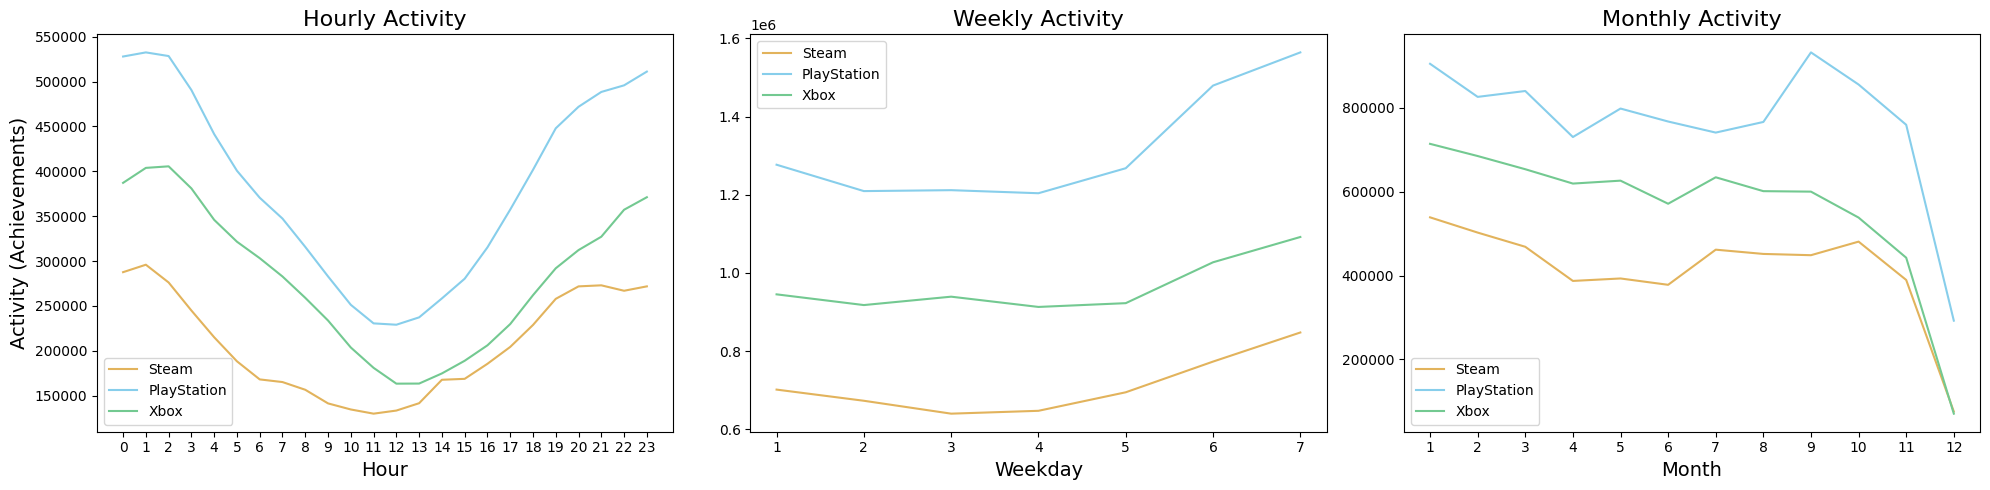

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    hourly = _activity(clear_activities[platform], 'hour')
    weekdays = _activity(clear_activities[platform], 'weekday')
    monthly = _activity(clear_activities[platform], 'month')

    sns.lineplot(x=hourly.hour, y=hourly.quantity, color=color, ax=axes[0], label=label)
    sns.lineplot(x=weekdays.weekday, y=weekdays.quantity, color=color, ax=axes[1], label=label)
    sns.lineplot(x=monthly.month, y=monthly.quantity, color=color, ax=axes[2], label=label)

axes[0].set_xlabel('Hour', fontsize=14)
axes[0].set_ylabel('Activity (Achievements)', fontsize=14)
axes[0].set_xticks(hourly.hour.unique())
axes[0].set_title('Hourly Activity', fontsize=16)
axes[0].legend()

axes[1].set_xlabel('Weekday', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_title('Weekly Activity', fontsize=16)
axes[1].legend()

axes[2].set_xlabel('Month', fontsize=14)
axes[2].set_ylabel('')
axes[2].set_xticks(monthly.month.unique())
axes[2].set_title('Monthly Activity', fontsize=16)
axes[2].legend()

plt.tight_layout()

**Conclusions:**
* Achievement manipulation was successfully detected, reducing noise in the data
* The line plots for the platforms are now 'separated' from each other.  
The highest activity is observed on the PlayStation platform
* Weekdays are less active compared to weekends
* Peak activity hours are in the evening and nighttime (most players are active between 6PM and 2AM)
* The `Monthly Activity` graph shows ambiguous trends

### **Metrics MAU, WAU**

In [15]:
# All weeks of the year
all_weeks = pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-MON')
all_weeks_df = pd.DataFrame({'week': all_weeks})
# All months of the year
all_months_df = pd.DataFrame({'month': list(range(1, 13))})

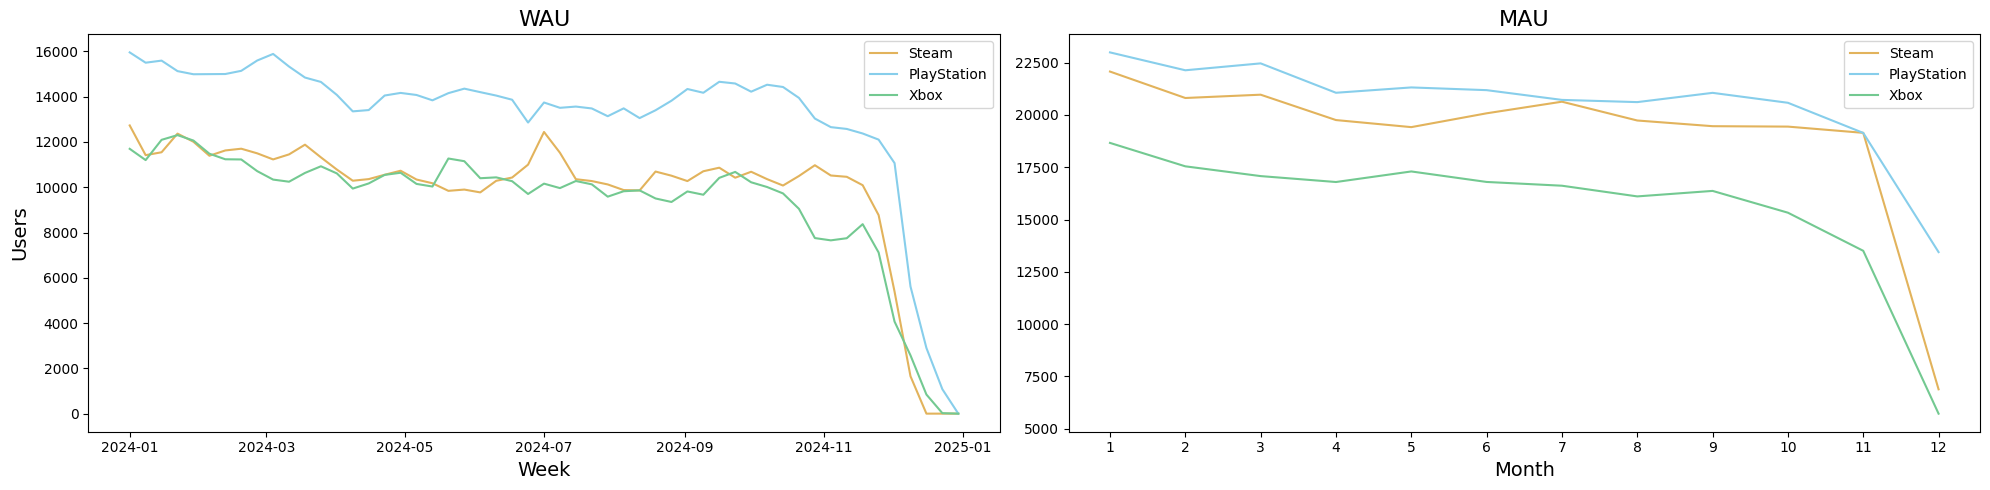

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    # Determine the start of the week for each activity
    clear_activities[platform]['week'] = clear_activities[platform].date_acquired - \
        pd.to_timedelta(clear_activities[platform].date_acquired.dt.dayofweek, unit='d')
    clear_activities[platform].week = clear_activities[platform].week.dt.date
    
    wau = clear_activities[platform].groupby('week', as_index=False).agg({'playerid': pd.Series.nunique})
    wau.week = pd.to_datetime(wau.week)
    wau = all_weeks_df.merge(wau, how='left').fillna(0).rename(columns={'playerid': 'users'})

    mau = clear_activities[platform].groupby('month', as_index=False).agg({'playerid': pd.Series.nunique})
    mau = all_months_df.merge(mau, how='left').fillna(0).rename(columns={'playerid': 'users'})

    sns.lineplot(x=wau.week, y=wau.users, color=color, ax=axes[0], label=label)
    sns.lineplot(x=mau.month, y=mau.users, color=color, ax=axes[1], label=label)
    
axes[0].set_xlabel('Week', fontsize=14)
axes[0].set_ylabel('Users', fontsize=14)
axes[0].set_title('WAU', fontsize=16)
axes[0].legend()

axes[1].set_xlabel('Month', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_xticks(mau.month.unique())
axes[1].set_title('MAU', fontsize=16)
axes[1].legend()

plt.tight_layout()

### **How often do users complete a game?**

> **Note:** Completion is defined as earning 100% of the achievements

In [17]:
# A dictionary where the keys are platform names,
# and the values are DataFrames of the number of achievements earned
completely = {}
for platform in PLATFORMS:
    completely[platform] = (
        clear_activities[platform]
        .groupby(['playerid', 'gameid'], as_index=False)
        .agg({'achievementid': 'count'})
        .rename(columns={'achievementid': 'obtained'})
    )
    completely[platform] = completely[platform].merge(achievements_df[platform], how='left')
    
    completely[platform]['ratio'] = completely[platform].obtained / completely[platform].total * 100

completely[PLATFORMS[0]].head(3)

,playerid,gameid,obtained,total,ratio
0,76561197960270682,431240,3,83,3.614458
1,76561197960270682,684410,4,26,15.384615
2,76561197960270682,1497440,10,17,58.823529


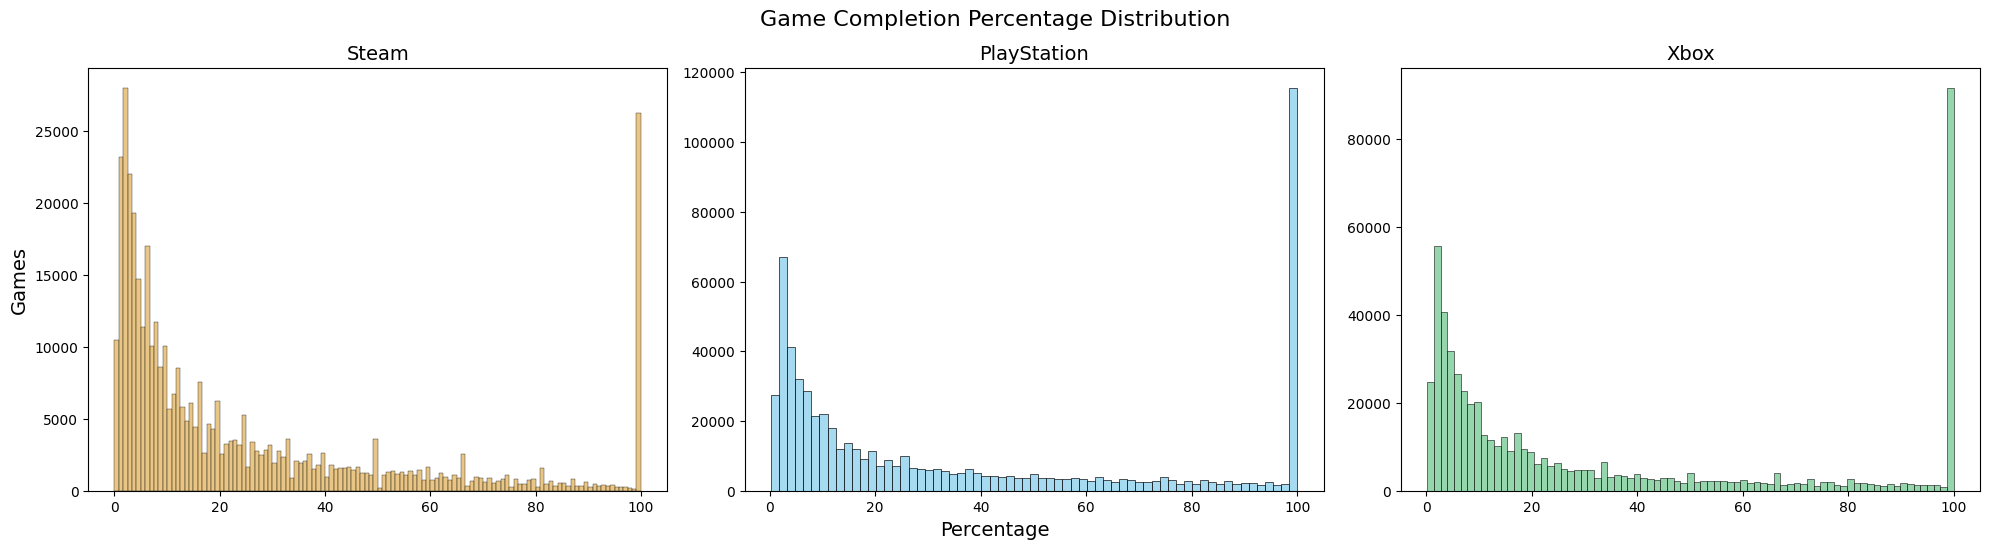

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.histplot(completely[platform].ratio, ax=ax, color=color)

    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0].set_ylabel('Games', fontsize=14)

fig.text(.5, 0, 'Percentage',
         ha='center', va='center', fontsize=14)
fig.text(.5, 1.02, 'Game Completion Percentage Distribution',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

*Observations:*
* The graphs exhibit distributions similar to a log-normal distribution, but with a significant extreme right-hand value 
* The `history` table contains only user activities, which is why there is no 0% value on the graph
* Most users do not complete the games they start
* A significant spike at 100% suggests that if the completion percentage is sufficiently high, it may motivate the user to reach 100% completion
* This trend is consistent across all platforms

> To ensure more accurate interpretation of the data, we will filter out the extreme left and right values (0% and 100%)  
> Subsequently, we will analyze the ratio of these values

In [19]:
for platform in PLATFORMS:
    completely[platform] = completely[platform].query('ratio != 100')

Let's apply the natural logarithm to the data to achieve a distribution closer to normal

In [20]:
for platform in PLATFORMS:
    completely[platform]['log_ratio'] = np.log(completely[platform].ratio)

completely[PLATFORMS[0]].head(3)

,playerid,gameid,obtained,total,ratio,log_ratio
0,76561197960270682,431240,3,83,3.614458,1.284942
1,76561197960270682,684410,4,26,15.384615,2.733368
2,76561197960270682,1497440,10,17,58.823529,4.074542


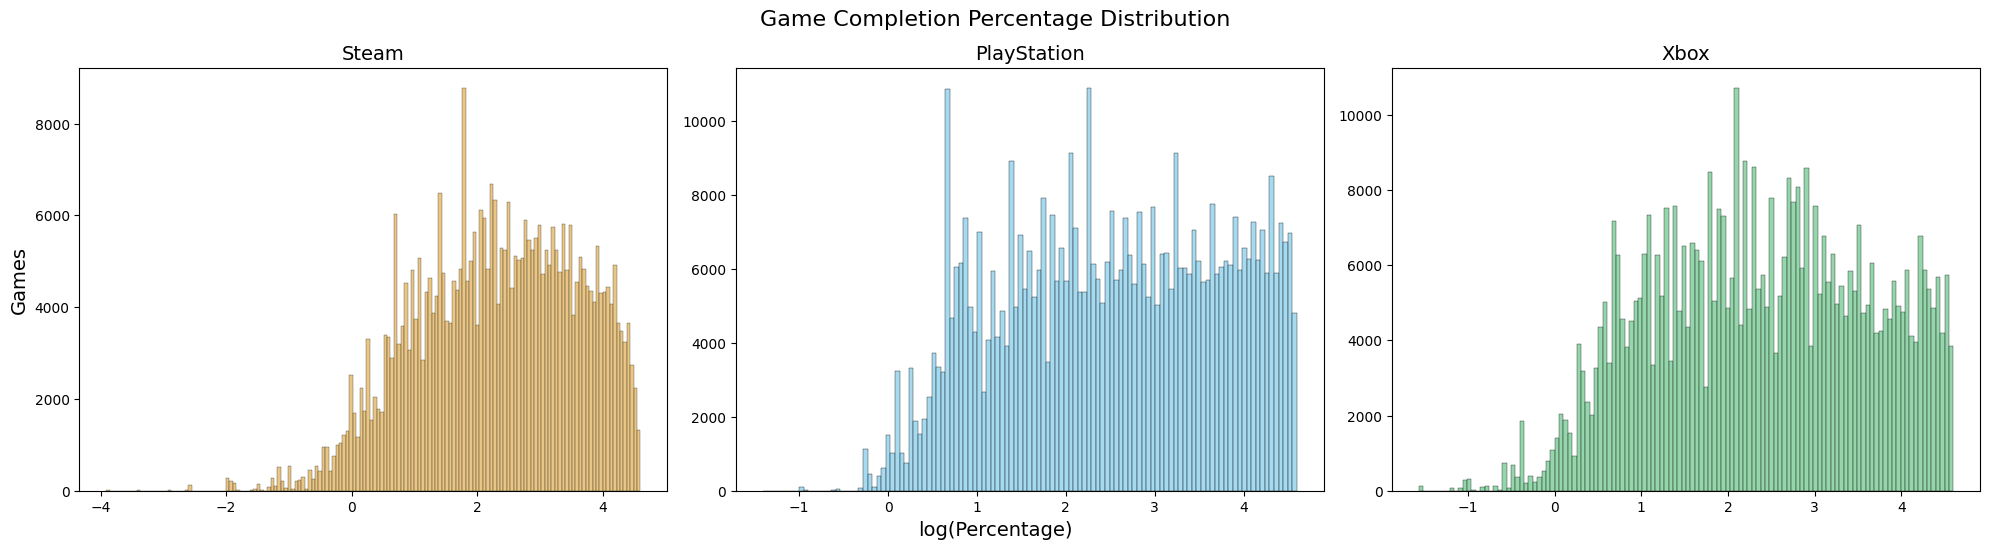

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.histplot(completely[platform].log_ratio, ax=ax, color=color)

    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0].set_ylabel('Games', fontsize=14)

fig.text(.5, 0, 'log(Percentage)',
         ha='center', va='center', fontsize=14)
fig.text(.5, 1.02, 'Game Completion Percentage Distribution',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

Since all distributions deviate from normal, we will use non-parametric methods

> ### **Kruskal-Wallis Test and Dunn's Test with Holm's Correction**

In [22]:
samples = [completely[platform].ratio for platform in PLATFORMS]

statistic, pvalue = stats.kruskal(samples[0], samples[1], samples[2])
if pvalue < ALPHA:
    print(f'Kruskal-Wallis Test\n' \
          f'Statistical significance was found — There are differences between the groups\n' \
          f'Probability: {pvalue.round(3)}  | Significance level: {ALPHA}')
else:
    print(f'Kruskal-Wallis Test\n' \
          f'No statistical significance was found — No differences were found between the groups\n' \
          f'Probability: {pvalue.round(3)}  | Significance level: {ALPHA}')

Kruskal-Wallis Test
Statistical significance was found — There are differences between the groups
Probability: 0.0  | Significance level: 0.05


In [23]:
for i, platform in enumerate(PLATFORMS):
    platform = platform.capitalize().replace('s', 'S')
    print(f'{platform} ({i + 1}): Average completion - {np.mean(samples[i]):.2f}%')

print('\nDunn`s Test with Holm`s Correction:')
print(posthoc_dunn(samples, p_adjust='holm'))

Steam (1): Average completion - 19.89%
PlayStation (2): Average completion - 23.87%
Xbox (3): Average completion - 21.20%

Dunn`s Test with Holm`s Correction:
              1    2             3
1  1.000000e+00  0.0  1.410384e-68
2  0.000000e+00  1.0  0.000000e+00
3  1.410384e-68  0.0  1.000000e+00


Statistical significance was found in each pairwise comparison. This indicates that, on average, the game completion percentage is higher on PlayStation compared to the other two platforms

Let's now consider the ratio of 0% to 100% completion

In [24]:
# A dictionary where the keys - platform names,
# and the values - DataFrames of the `purchased_games` table
purchased_games_df = {}
for platform in PLATFORMS:
    purchased_games_df[platform] = postgres_data(platform, 'purchased_games')

purchased_games_df[PLATFORMS[0]].head(3)

,playerid,library
0,76561198060698936,"[60, 1670, 3830, 1600, 2900, 2910, 2920, 4800,..."
1,76561198287452552,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
2,76561198040436563,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."
